In [ ]:
# --------------------------------------------------
# 01_eda.ipynb
# Predicting Shipment Delays - Exploratory Analysis
# Author: Mohamed Sahidu Bah
# --------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_fscore_support
)

In [ ]:
df = pd.read_csv('logistics_shipments_dataset.csv')

In [ ]:
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Shipment_ID       2000 non-null   object 
 1   Origin_Warehouse  2000 non-null   object 
 2   Destination       2000 non-null   object 
 3   Carrier           2000 non-null   object 
 4   Shipment_Date     2000 non-null   object 
 5   Delivery_Date     1968 non-null   object 
 6   Weight_kg         2000 non-null   float64
 7   Cost              1959 non-null   float64
 8   Status            2000 non-null   object 
 9   Distance_miles    2000 non-null   int64  
 10  Transit_Days      2000 non-null   int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 172.0+ KB


In [ ]:
df.dtypes

,0
Shipment_ID,object
Origin_Warehouse,object
Destination,object
Carrier,object
Shipment_Date,object
Delivery_Date,object
Weight_kg,float64
Cost,float64
Status,object
Distance_miles,int64


In [ ]:
df['Status'].value_counts()

,count
Status,
Delivered,1648
Delayed,199
In Transit,76
Lost,45
Returned,32


In [ ]:
df.shape

(2000, 11)

In [ ]:
df.isnull().sum()

,0
Shipment_ID,0
Origin_Warehouse,0
Destination,0
Carrier,0
Shipment_Date,0
Delivery_Date,32
Weight_kg,0
Cost,41
Status,0
Distance_miles,0


In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
1995,False
1996,False
1997,False
1998,False


In [ ]:
df["Shipment_Date"] = pd.to_datetime(df["Shipment_Date"])
df["Delivery_Date"] = pd.to_datetime(df["Delivery_Date"])

In [ ]:
df["Shipment_Date"].dtype

dtype('<M8[ns]')

In [ ]:
# Filling the missing Delivery date using shipment date plus Transit Days

df.loc[df['Delivery_Date'].isna(), 'Delivery_Date'] = (df['Shipment_Date'] + pd.to_timedelta(df['Transit_Days'], unit='D'))

In [ ]:
df['Delivery_Date'].isna().sum()

np.int64(0)

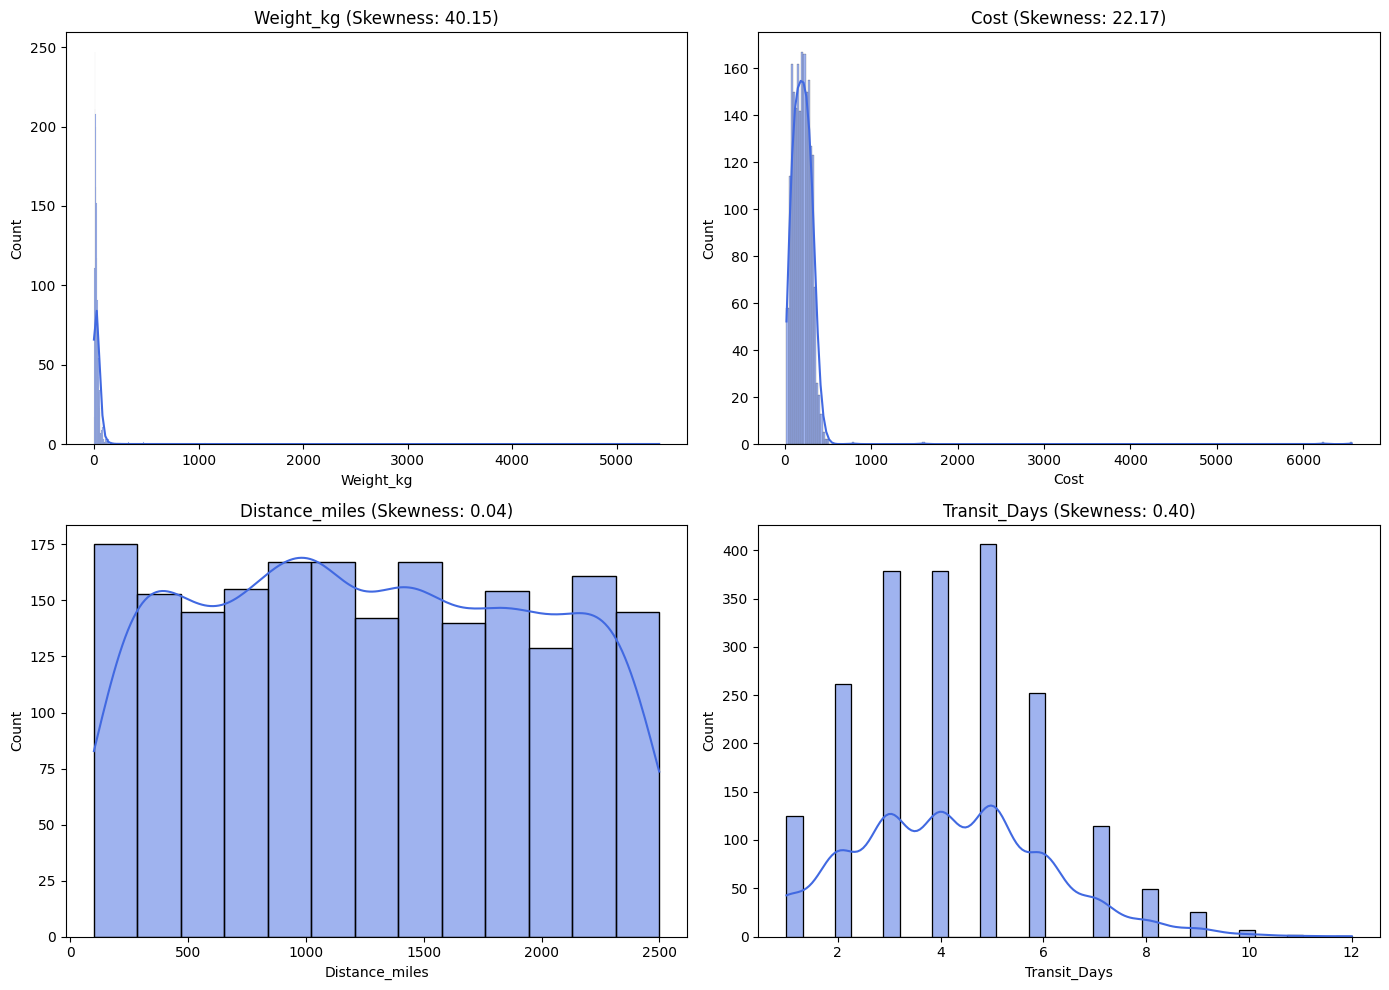

In [ ]:
# checking for skweness and outliers on contenous various

con_var = ["Weight_kg", "Cost", "Distance_miles", "Transit_Days"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(con_var, 1):
    plt.subplot(2, 2, i)
    skew_val = df[col].skew()
    sns.histplot(df[col], kde=True, color='royalblue')
    plt.title(f"{col} (Skewness: {skew_val:.2f})")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

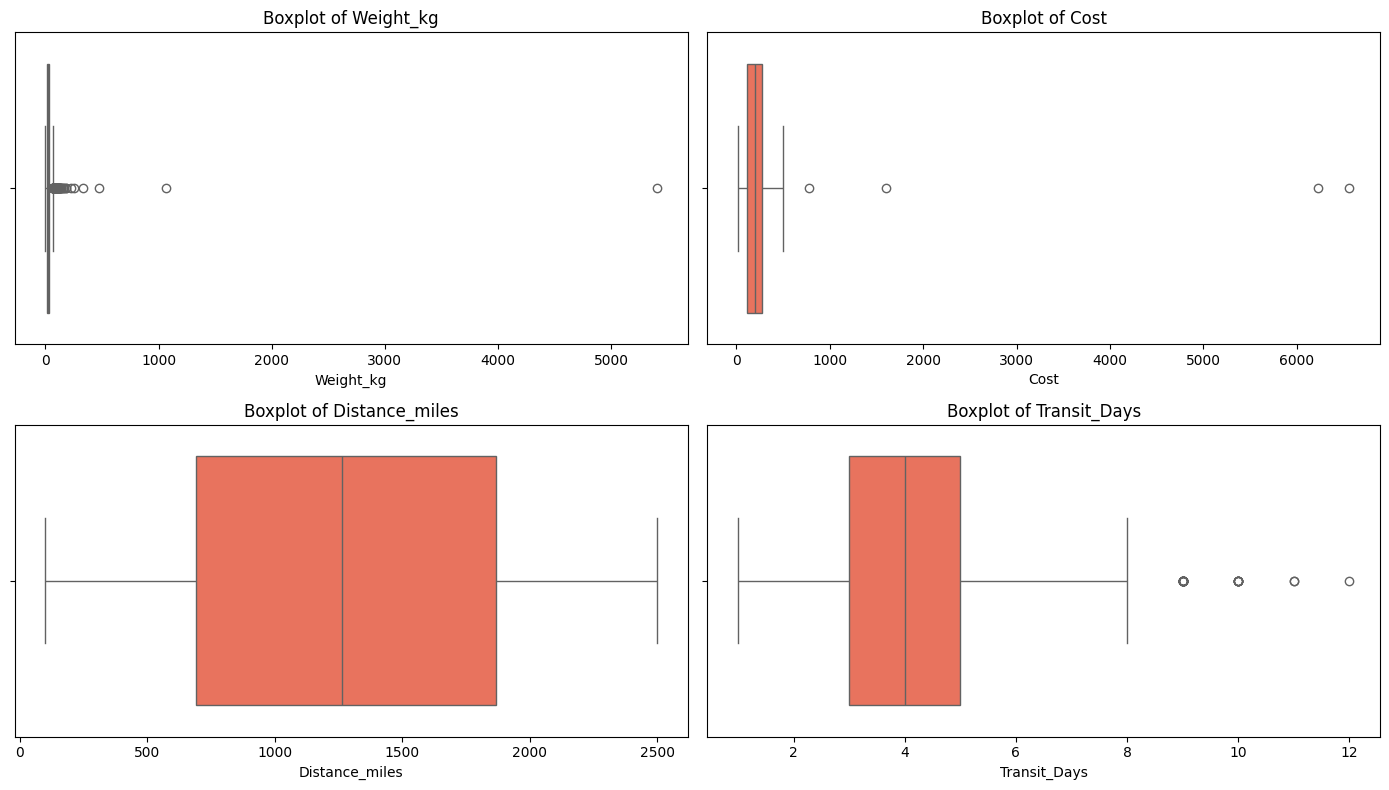

In [ ]:
plt.figure(figsize=(14, 8))

for i, col in enumerate(con_var, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=df[col], color='tomato')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# preprosessing for weight_kg and cost
# I keep Distance_miles as is (symmetric, no outliers)
# I keep Transit_Days as is (operational variable)

# Median imputation for skewed cost variable
df['Cost'] = df['Cost'].fillna(df['Cost'].median())

# Log transformations for skewed variables
df['Weight_kg_log'] = np.log1p(df['Weight_kg'])
df['Cost_log'] = np.log1p(df['Cost'])

In [ ]:
# creating target variable is_delayed

delay_mapping = {
    "Delivered": 0,
    "In Transit": 0,
    "Delayed": 1,
    "Lost": 1,
    "Returned": 1
}

df['is_delayed'] = df['Status'].map(delay_mapping)
df['is_delayed'].value_counts()

,count
is_delayed,
0,1724
1,276


In [ ]:
# feature engineering
# Actual transit days (from cleaned Delivery_Date)
df['actual_transit_days'] = (df['Delivery_Date'] - df['Shipment_Date']).dt.days

# Difference between planned and actual
df['planned_vs_actual_diff'] = df['actual_transit_days'] - df['Transit_Days']

# Shipment month
df['shipment_month'] = df['Shipment_Date'].dt.month

# Day of week (0 = Monday)
df['shipment_dayofweek'] = df['Shipment_Date'].dt.dayofweek

# Weekend indicator
df['is_weekend_shipment'] = df['shipment_dayofweek'].isin([5, 6]).astype(int)

# Route feature
df['route'] = df['Origin_Warehouse'] + "_" + df['Destination']

In [ ]:
df.head()

,Shipment_ID,Origin_Warehouse,Destination,Carrier,Shipment_Date,Delivery_Date,Weight_kg,Cost,Status,Distance_miles,Transit_Days,Weight_kg_log,Cost_log,is_delayed,actual_transit_days,planned_vs_actual_diff,shipment_month,shipment_dayofweek,is_weekend_shipment,route
0,SH10000,Warehouse_MIA,San Francisco,UPS,2023-10-02,2023-10-04,25.7,67.46,Delivered,291,2,3.284664,4.226250,0,2,0,10,0,0,Warehouse_MIA_San Francisco
1,SH10001,Warehouse_MIA,Atlanta,DHL,2023-12-06,2023-12-09,38.9,268.85,Delivered,1225,3,3.686376,5.597866,0,3,0,12,2,0,Warehouse_MIA_Atlanta
2,SH10002,Warehouse_LA,Houston,DHL,2023-09-18,2023-09-20,37.2,74.35,Delivered,220,2,3.642836,4.322144,0,2,0,9,0,0,Warehouse_LA_Houston
3,SH10003,Warehouse_BOS,Seattle,OnTrac,2023-01-26,2023-02-04,42.6,187.04,Delivered,1156,9,3.775057,5.236655,0,9,0,1,3,0,Warehouse_BOS_Seattle
4,SH10004,Warehouse_SF,Dallas,OnTrac,2023-06-03,2023-06-06,7.9,120.01,Delivered,1017,3,2.186051,4.795873,0,3,0,6,5,1,Warehouse_SF_Dallas


In [ ]:
# droping irrelevant or near zero-variance columns

df_model = df.drop(columns=[
    "Shipment_ID",
    "Status",
    "Shipment_Date",
    "Delivery_Date"
], errors="ignore")

df_model.head()

,Origin_Warehouse,Destination,Carrier,Weight_kg,Cost,Distance_miles,Transit_Days,Weight_kg_log,Cost_log,is_delayed,actual_transit_days,planned_vs_actual_diff,shipment_month,shipment_dayofweek,is_weekend_shipment,route
0,Warehouse_MIA,San Francisco,UPS,25.7,67.46,291,2,3.284664,4.226250,0,2,0,10,0,0,Warehouse_MIA_San Francisco
1,Warehouse_MIA,Atlanta,DHL,38.9,268.85,1225,3,3.686376,5.597866,0,3,0,12,2,0,Warehouse_MIA_Atlanta
2,Warehouse_LA,Houston,DHL,37.2,74.35,220,2,3.642836,4.322144,0,2,0,9,0,0,Warehouse_LA_Houston
3,Warehouse_BOS,Seattle,OnTrac,42.6,187.04,1156,9,3.775057,5.236655,0,9,0,1,3,0,Warehouse_BOS_Seattle
4,Warehouse_SF,Dallas,OnTrac,7.9,120.01,1017,3,2.186051,4.795873,0,3,0,6,5,1,Warehouse_SF_Dallas


In [ ]:
df_model.info()
df_model.head()
df_model['is_delayed'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Origin_Warehouse        2000 non-null   object 
 1   Destination             2000 non-null   object 
 2   Carrier                 2000 non-null   object 
 3   Weight_kg               2000 non-null   float64
 4   Cost                    2000 non-null   float64
 5   Distance_miles          2000 non-null   int64  
 6   Transit_Days            2000 non-null   int64  
 7   Weight_kg_log           2000 non-null   float64
 8   Cost_log                2000 non-null   float64
 9   is_delayed              2000 non-null   int64  
 10  actual_transit_days     2000 non-null   int64  
 11  planned_vs_actual_diff  2000 non-null   int64  
 12  shipment_month          2000 non-null   int32  
 13  shipment_dayofweek      2000 non-null   int32  
 14  is_weekend_shipment     2000 non-null   

,proportion
is_delayed,
0,0.862
1,0.138


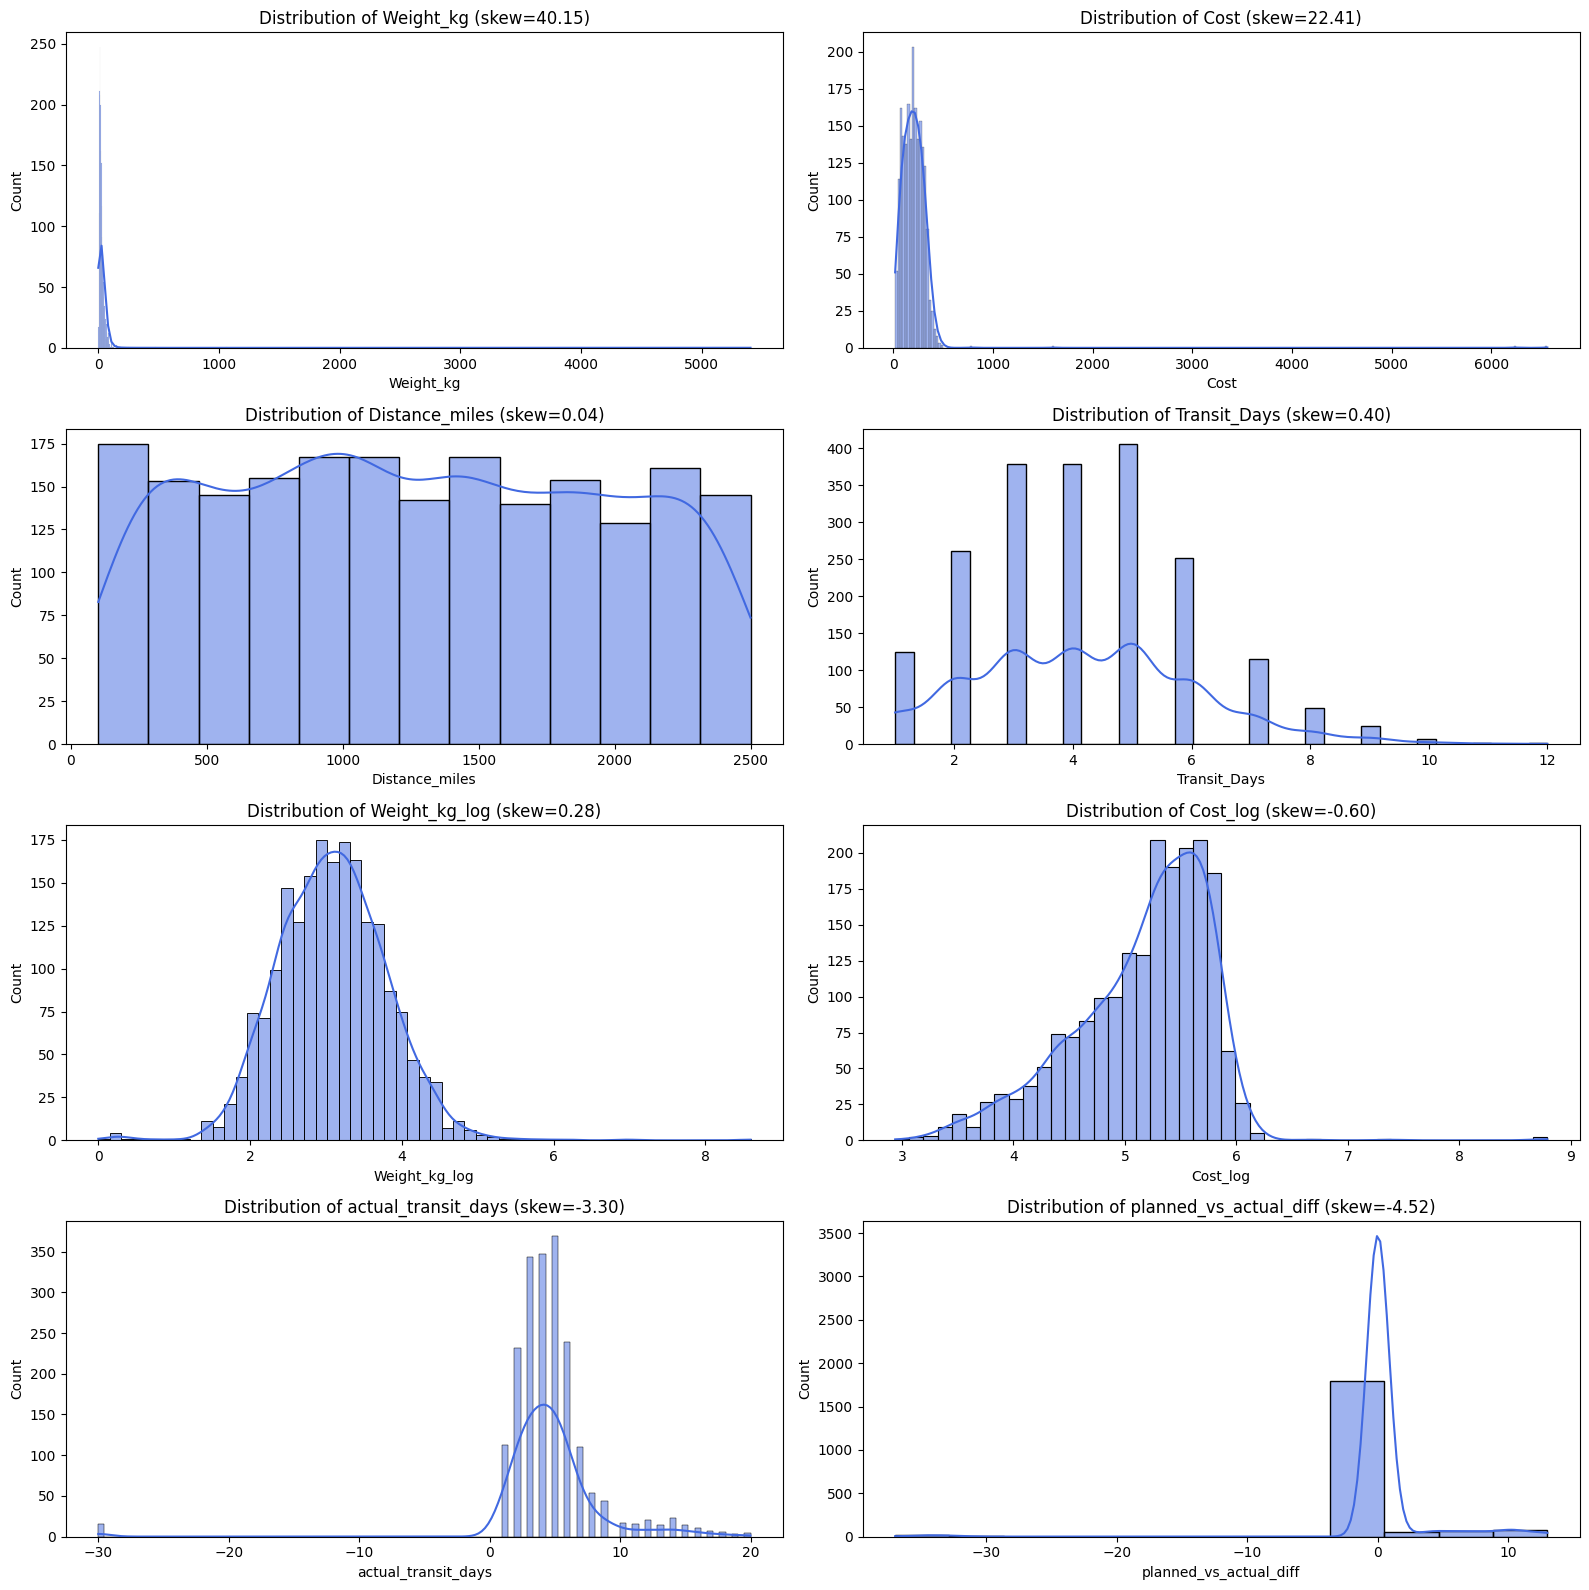

In [ ]:
# Final Hist for contenous variables


numeric_cols = [
    "Weight_kg", "Cost", "Distance_miles", "Transit_Days",
    "Weight_kg_log", "Cost_log", "actual_transit_days",
    "planned_vs_actual_diff"
]

plt.figure(figsize=(16, 16))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df_model[col], kde=True, color='royalblue')
    plt.title(f"Distribution of {col} (skew={df_model[col].skew():.2f})")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

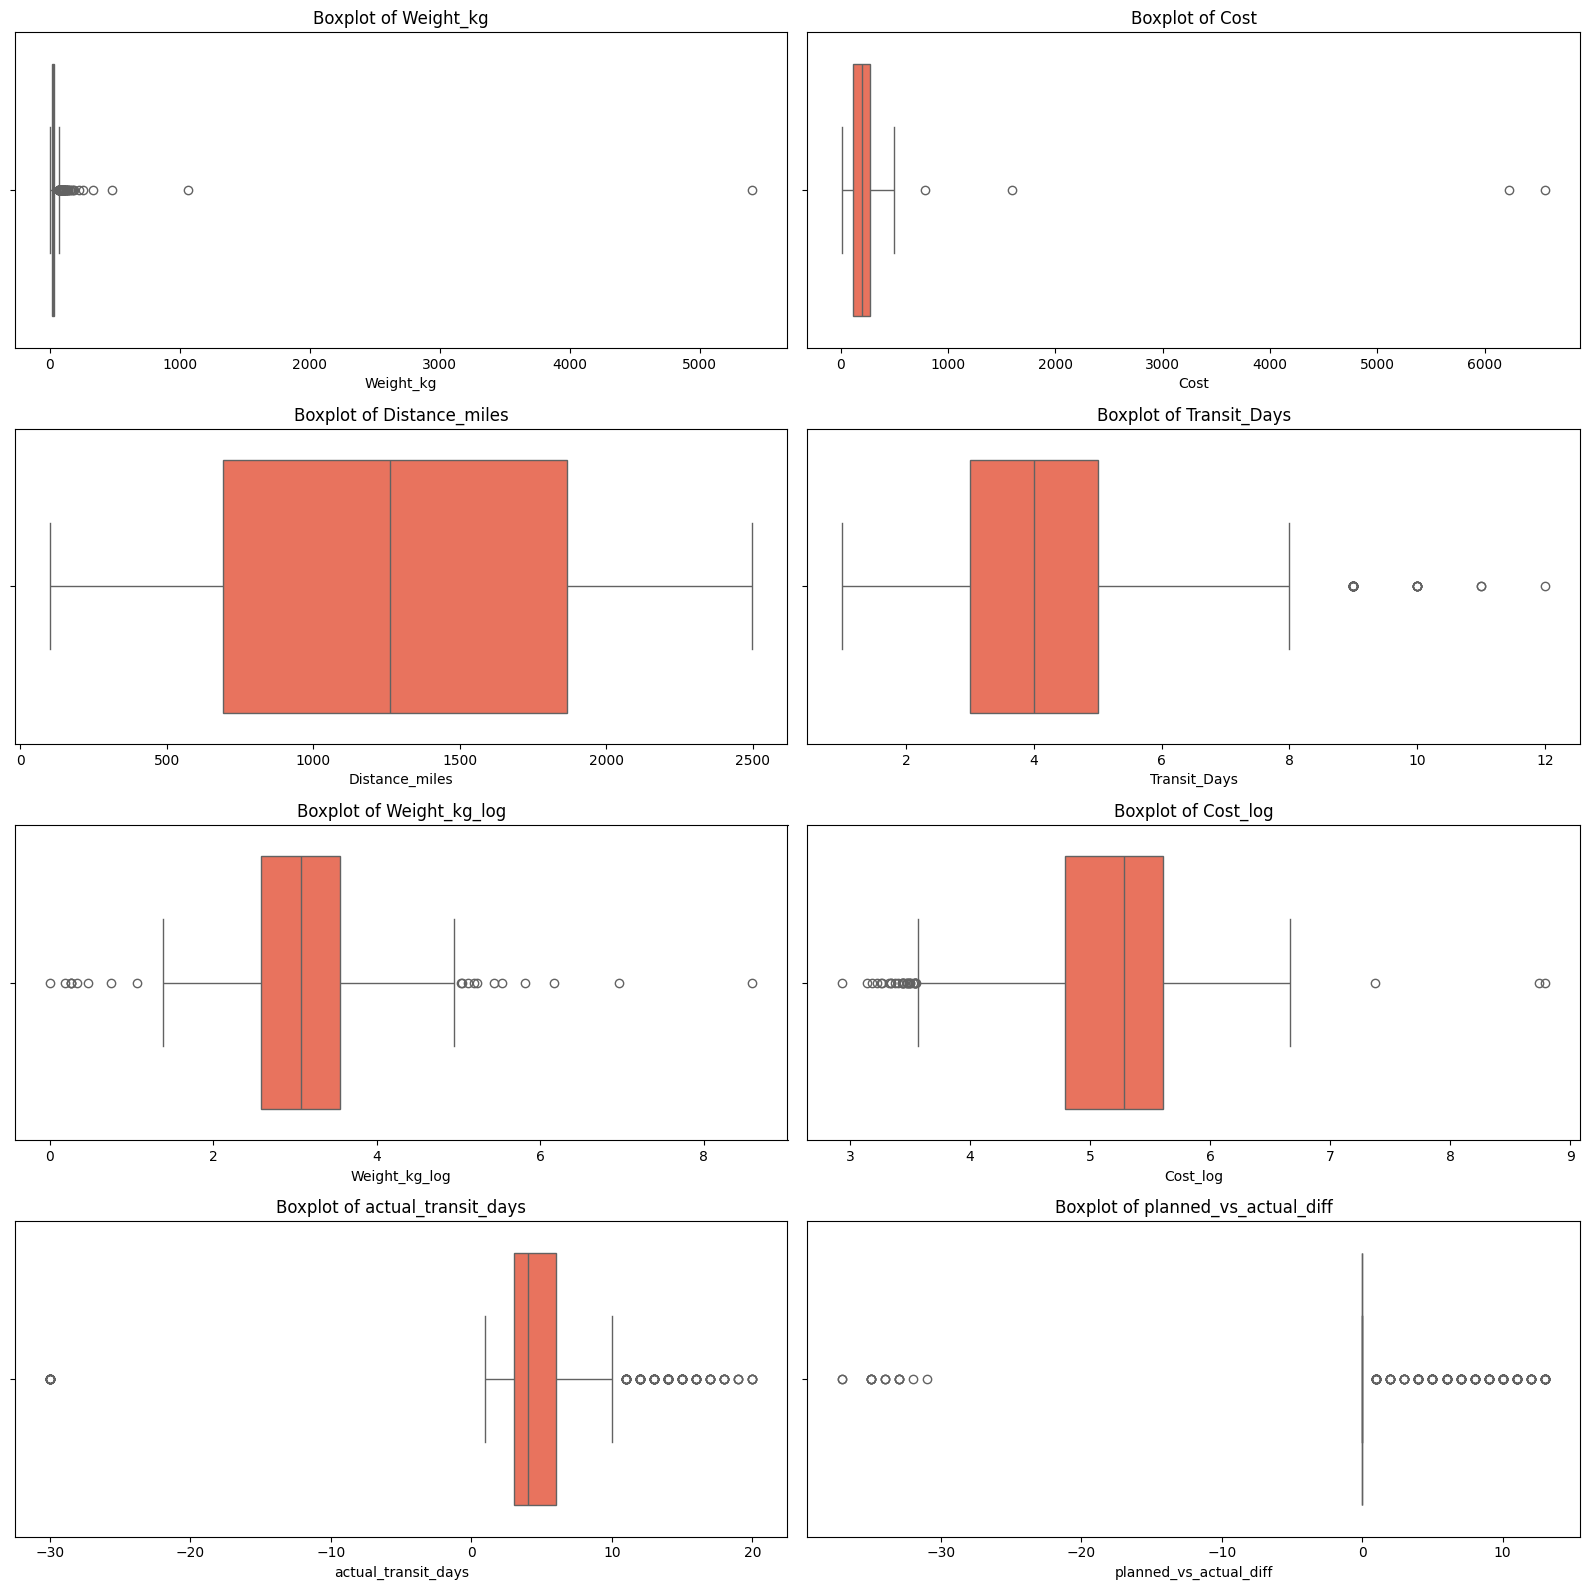

In [ ]:
# final boxplots for contenous variables

plt.figure(figsize=(16, 16))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(x=df_model[col], color='tomato')
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

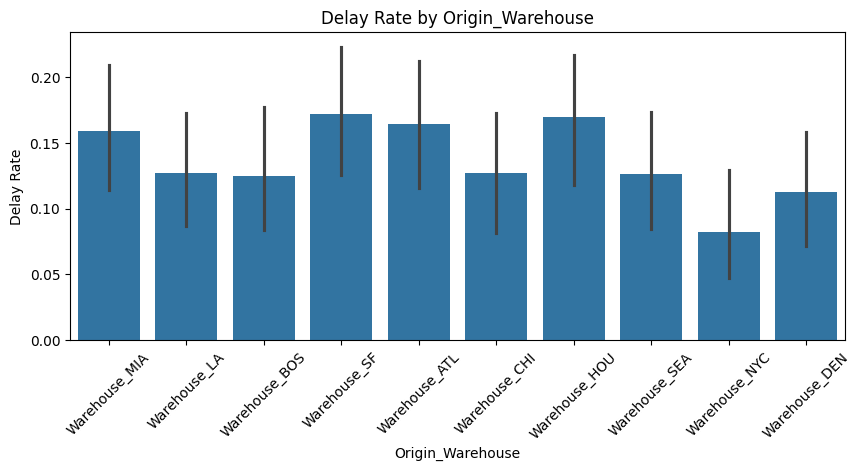

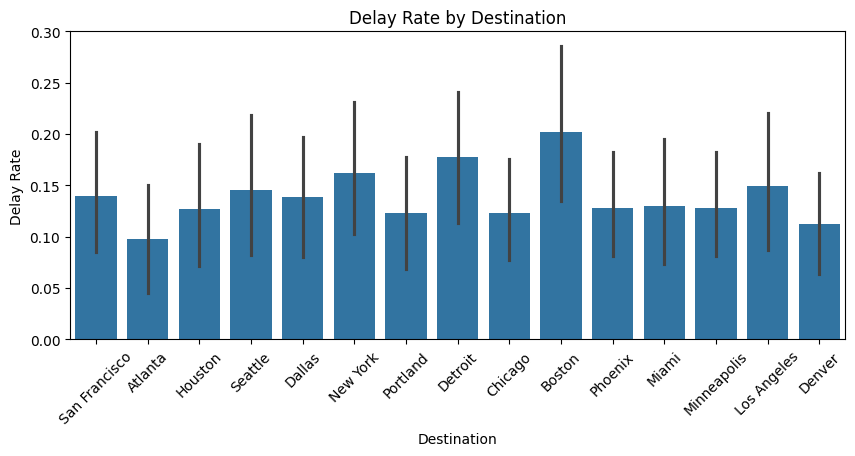

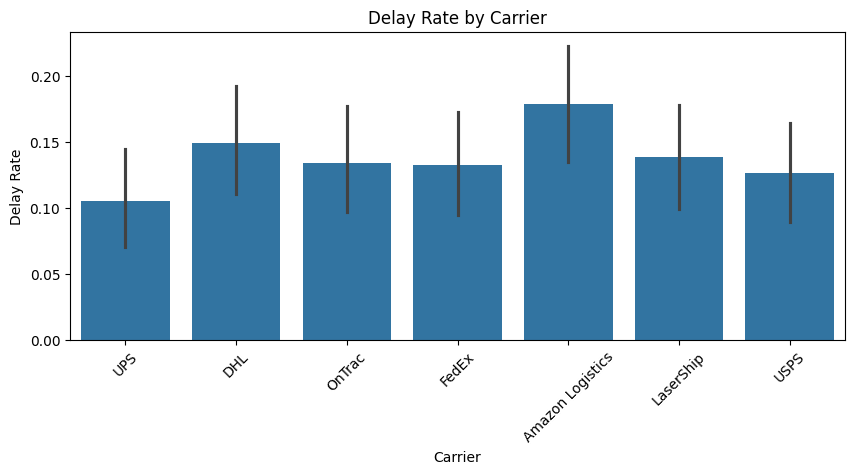

In [ ]:
# barplot for categorical variables

cat_var = ["Origin_Warehouse", "Destination", "Carrier"]

for col in cat_var:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=col, y="is_delayed", data=df_model, estimator=lambda x: sum(x)/len(x))
    plt.title(f"Delay Rate by {col}")
    plt.xticks(rotation=45)
    plt.ylabel("Delay Rate")
    plt.show()

In [ ]:
# correlation between raw and log variables


raw_log_pairs = [
    ("Weight_kg", "Weight_kg_log"),
    ("Cost", "Cost_log")
]

for raw, log in raw_log_pairs:
    corr = df_model[[raw, log]].corr().iloc[0,1]
    print(f"Correlation between {raw} and {log}: {corr:.4f}")

Correlation between Weight_kg and Weight_kg_log: 0.3493
Correlation between Cost and Cost_log: 0.5827


In [ ]:
# Selecting numeric columns for VIF
numeric_cols = [
    "Weight_kg", "Cost", "Distance_miles", "Transit_Days",
    "Weight_kg_log", "Cost_log",
    "actual_transit_days", "planned_vs_actual_diff",
    "shipment_month", "shipment_dayofweek", "is_weekend_shipment"
]

X_numeric = df_model[numeric_cols].copy()

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i)
                   for i in range(len(X_numeric.columns))]

vif_data

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,Weight_kg,1.212025
1,Cost,2.338092
2,Distance_miles,14.077324
3,Transit_Days,inf
4,Weight_kg_log,27.666549
5,Cost_log,63.815045
6,actual_transit_days,inf
7,planned_vs_actual_diff,inf
8,shipment_month,4.911239
9,shipment_dayofweek,8.391083


In [ ]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(
    df_model,
    columns=["Origin_Warehouse", "Destination", "Carrier", "route"],
    drop_first=True  # to avoid multicollinearity
)

df_encoded.head()

,Weight_kg,Cost,Distance_miles,Transit_Days,Weight_kg_log,Cost_log,is_delayed,actual_transit_days,planned_vs_actual_diff,shipment_month,...,route_Warehouse_SF_Detroit,route_Warehouse_SF_Houston,route_Warehouse_SF_Los Angeles,route_Warehouse_SF_Miami,route_Warehouse_SF_Minneapolis,route_Warehouse_SF_New York,route_Warehouse_SF_Phoenix,route_Warehouse_SF_Portland,route_Warehouse_SF_San Francisco,route_Warehouse_SF_Seattle
0,25.7,67.46,291,2,3.284664,4.226250,0,2,0,10,...,False,False,False,False,False,False,False,False,False,False
1,38.9,268.85,1225,3,3.686376,5.597866,0,3,0,12,...,False,False,False,False,False,False,False,False,False,False
2,37.2,74.35,220,2,3.642836,4.322144,0,2,0,9,...,False,False,False,False,False,False,False,False,False,False
3,42.6,187.04,1156,9,3.775057,5.236655,0,9,0,1,...,False,False,False,False,False,False,False,False,False,False
4,7.9,120.01,1017,3,2.186051,4.795873,0,3,0,6,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# data spliting

X = df_encoded.drop(columns=["is_delayed"])
y = df_encoded["is_delayed"]

# Stratified split keeps class ratio consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

X_train.shape, X_test.shape

((1600, 189), (400, 189))

In [ ]:
# data for LR

# Starting from the fully encoded dataset
df_lr = df_encoded.copy()

# droping multicollinear / unnecessary features
lr_drop_cols = [
    "Weight_kg",            # drop raw
    "Cost",                 # drop raw
    "Transit_Days",         # perfect collinearity with other transit vars
    "actual_transit_days",
    # keep planned_vs_actual_diff ONLY
]

df_lr = df_lr.drop(columns=lr_drop_cols, errors="ignore")

df_lr.head()

,Distance_miles,Weight_kg_log,Cost_log,is_delayed,planned_vs_actual_diff,shipment_month,shipment_dayofweek,is_weekend_shipment,Origin_Warehouse_Warehouse_BOS,Origin_Warehouse_Warehouse_CHI,...,route_Warehouse_SF_Detroit,route_Warehouse_SF_Houston,route_Warehouse_SF_Los Angeles,route_Warehouse_SF_Miami,route_Warehouse_SF_Minneapolis,route_Warehouse_SF_New York,route_Warehouse_SF_Phoenix,route_Warehouse_SF_Portland,route_Warehouse_SF_San Francisco,route_Warehouse_SF_Seattle
0,291,3.284664,4.226250,0,0,10,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1225,3.686376,5.597866,0,0,12,2,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,220,3.642836,4.322144,0,0,9,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1156,3.775057,5.236655,0,0,1,3,0,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1017,2.186051,4.795873,0,0,6,5,1,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# splitting data for LR
X_lr = df_lr.drop(columns=["is_delayed"])
y_lr = df_lr["is_delayed"]

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr,
    y_lr,
    test_size=0.2,
    stratify=y_lr,
    random_state=42
)

X_train_lr.shape, X_test_lr.shape

((1600, 185), (400, 185))

In [ ]:
# Standardization for LR


lr_numeric_features = [
    "Weight_kg_log",
    "Cost_log",
    "planned_vs_actual_diff",
    "Distance_miles",
    "shipment_month",
    "shipment_dayofweek",
    "is_weekend_shipment"
]



scaler = StandardScaler()

# Fit on train only
X_train_lr[lr_numeric_features] = scaler.fit_transform(
    X_train_lr[lr_numeric_features]
)

# Transform test
X_test_lr[lr_numeric_features] = scaler.transform(
    X_test_lr[lr_numeric_features]
)

In [ ]:
# Logistic Regression


l_r = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   # handle class imbalance
    n_jobs=-1
)

l_r.fit(X_train_lr, y_train_lr)

LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

In [ ]:
y_pred_lr = l_r.predict(X_test_lr)
y_proba_lr = l_r.predict_proba(X_test_lr)[:, 1]  # probability of class 1 (delayed)

In [ ]:
print("=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test_lr, y_pred_lr, digits=4))

roc_lr = roc_auc_score(y_test_lr, y_proba_lr)
print("ROC-AUC (Logistic Regression):", roc_lr)

# Get precision/recall/F1 specifically for delayed class (1)
precision_1, recall_1, f1_1, _ = precision_recall_fscore_support(
    y_test_lr, y_pred_lr, pos_label=1, average="binary"
)
print(f"Delayed class -> Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1: {f1_1:.4f}")

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.9308    0.9362    0.9335       345
           1     0.5849    0.5636    0.5741        55

    accuracy                         0.8850       400
   macro avg     0.7579    0.7499    0.7538       400
weighted avg     0.8833    0.8850    0.8841       400

ROC-AUC (Logistic Regression): 0.7372332015810277
Delayed class -> Precision: 0.5849, Recall: 0.5636, F1: 0.5741


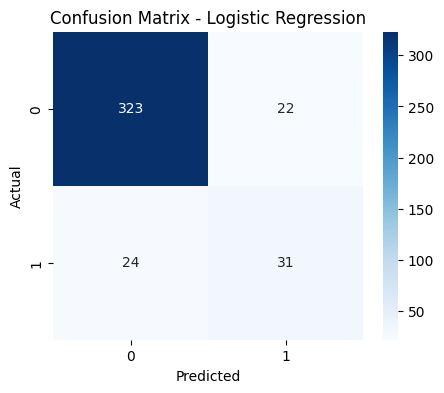

In [ ]:
# confusion matrix for LR

cm = confusion_matrix(y_test_lr, y_pred_lr)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
# random forest

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",   # handles the 13.8% delayed imbalance
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [ ]:
print("=== RANDOM FOREST ===")
print(classification_report(y_test, y_pred_rf, digits=4))

rf_auc = roc_auc_score(y_test, y_proba_rf)
print("ROC-AUC (Random Forest):", rf_auc)

=== RANDOM FOREST ===
              precision    recall  f1-score   support

           0     0.9350    1.0000    0.9664       345
           1     1.0000    0.5636    0.7209        55

    accuracy                         0.9400       400
   macro avg     0.9675    0.7818    0.8437       400
weighted avg     0.9439    0.9400    0.9326       400

ROC-AUC (Random Forest): 0.7637417654808959


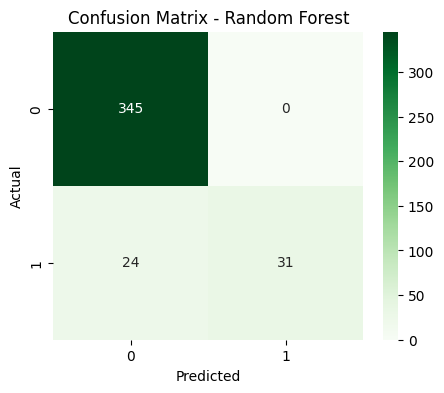

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

top_n = 20
print("=== TOP 20 RF FEATURES ===")
for i in range(top_n):
    print(f"{feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

=== TOP 20 RF FEATURES ===
planned_vs_actual_diff: 0.2831
actual_transit_days: 0.1745
Cost_log: 0.0456
Distance_miles: 0.0435
Cost: 0.0428
Weight_kg_log: 0.0425
Weight_kg: 0.0424
shipment_month: 0.0292
Transit_Days: 0.0259
shipment_dayofweek: 0.0227
Carrier_LaserShip: 0.0065
is_weekend_shipment: 0.0063
Carrier_USPS: 0.0061
Origin_Warehouse_Warehouse_SF: 0.0060
Carrier_OnTrac: 0.0059
Carrier_FedEx: 0.0056
Carrier_UPS: 0.0054
Carrier_DHL: 0.0054
Origin_Warehouse_Warehouse_MIA: 0.0051
route_Warehouse_ATL_Denver: 0.0042


In [ ]:
# XGBoost

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred_xgb, digits=4))

xgb_auc = roc_auc_score(y_test, y_proba_xgb)
print("ROC-AUC (XGBoost):", xgb_auc)

              precision    recall  f1-score   support

           0     0.9373    0.9971    0.9663       345
           1     0.9697    0.5818    0.7273        55

    accuracy                         0.9400       400
   macro avg     0.9535    0.7895    0.8468       400
weighted avg     0.9418    0.9400    0.9334       400

ROC-AUC (XGBoost): 0.8002635046113307


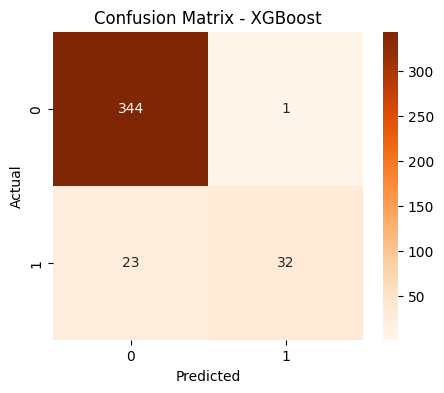

In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
xgb_importances = xgb.feature_importances_

indices = np.argsort(xgb_importances)[::-1]

print("=== TOP 20 XGB FEATURES ===")
for i in range(20):
    print(f"{feature_names[indices[i]]}: {xgb_importances[indices[i]]:.4f}")

=== TOP 20 XGB FEATURES ===
planned_vs_actual_diff: 0.4313
actual_transit_days: 0.0397
route_Warehouse_MIA_Chicago: 0.0295
route_Warehouse_SF_Detroit: 0.0231
route_Warehouse_BOS_Portland: 0.0223
route_Warehouse_ATL_Minneapolis: 0.0204
route_Warehouse_SF_New York: 0.0181
Transit_Days: 0.0168
Destination_Seattle: 0.0153
Carrier_DHL: 0.0150
Destination_Houston: 0.0148
Carrier_LaserShip: 0.0134
Destination_Chicago: 0.0132
route_Warehouse_HOU_Miami: 0.0126
Carrier_USPS: 0.0123
Origin_Warehouse_Warehouse_MIA: 0.0123
Carrier_UPS: 0.0121
Origin_Warehouse_Warehouse_LA: 0.0118
Destination_Phoenix: 0.0117
Destination_Miami: 0.0108
